# Simplified Monte Carlo w/o GBM

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

import yfinance as yf

In [34]:
# import NVDA stock data from 1 Jan 2024 - 30 Nov 2025

start_date = "2024-01-01"
end_date = "2025-11-30"
ticker = "NVDA"

nvda = yf.download(ticker, start_date, end_date, auto_adjust = False)
nvda.tail(5)

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2025-11-21,178.870041,178.880005,184.559998,172.929993,181.240005,346926200
2025-11-24,182.539841,182.550003,183.500000,176.479996,179.490005,256618300
2025-11-25,177.810104,177.820007,178.160004,169.550003,174.910004,320600300
2025-11-26,180.249954,180.259995,182.910004,178.240005,181.630005,183852000
2025-11-28,176.990143,177.000000,179.289993,176.500000,179.009995,121332800


In [35]:
# daily log returns
nvda["Log Return"] = np.log(nvda["Adj Close"] / nvda["Adj Close"].shift(1)).dropna()

In [36]:
# compute mean and standard deviation of log returns
mu = nvda["Log Return"].mean()
sigma = nvda["Log Return"].std()

In [37]:
T = 252     # time period of interest for Monte Carlo simulation

S0 = nvda["Adj Close"].iloc[-1]     # initial stock price, i.e. starting point for all simulated price paths
S0 = float(S0)

num_sim = 1000      # number of simulations

/var/folders/n6/ym49749x32x4hyjj33rg8yf80000gn/T/ipykernel_50759/2553691955.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(S0)


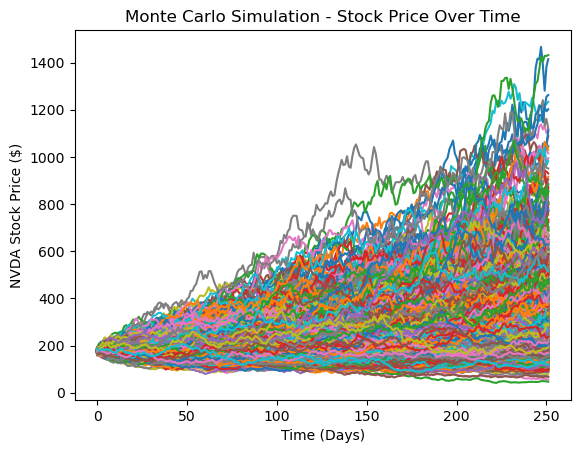

In [38]:
# monte carlo simulation
for i in range(num_sim):
    sim_rets = np.random.normal(mu, sigma, T)
    sim_prices = S0 * (sim_rets + 1).cumprod()
    
    plt.plot(sim_prices)
    plt.xlabel("Time (Days)")
    plt.ylabel("NVDA Stock Price ($)")
    plt.title("Monte Carlo Simulation - Stock Price Over Time")


In [39]:
# 1000 scenarios with 252 daily returns per scenario
simulated_rets = np.random.normal(mu, sigma, (1000, T))

# collapse each scenario into a single annual return (log-compounded), i.e. total return over the horizon
horizon_returns = np.exp(np.sum(np.log(1 + simulated_rets), axis = 1)) - 1

# compute VaR over the year (~252 trading days), accounting for all 1000 scenarios
VaR95 = np.percentile(horizon_returns, 5)   # 95% annual VaR
VaR99 = np.percentile(horizon_returns, 1)   # 99% annual Var

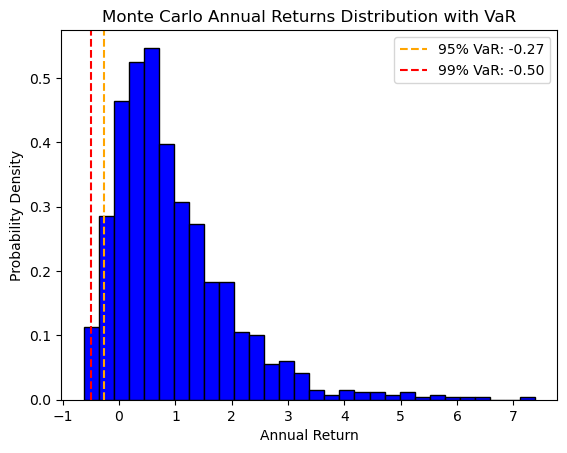

In [47]:
plt.hist(horizon_returns, bins = 30, density = True, color = "blue", edgecolor = "black")
plt.axvline(VaR95, color = "orange", linestyle = "--", label = f"95% VaR: {VaR95:.2f}")
plt.axvline(VaR99, color = "red", linestyle = "--", label = f"99% VaR: {VaR99:.2f}")

plt.xlabel("Annual Return")
plt.ylabel("Probability Density")
plt.title("Monte Carlo Annual Returns Distribution with VaR")
plt.legend()
plt.show()
